<a href="https://colab.research.google.com/github/njafarov/Optimization_LP/blob/main/Ralph_Calvin_Hilfiger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 10.6 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
P

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

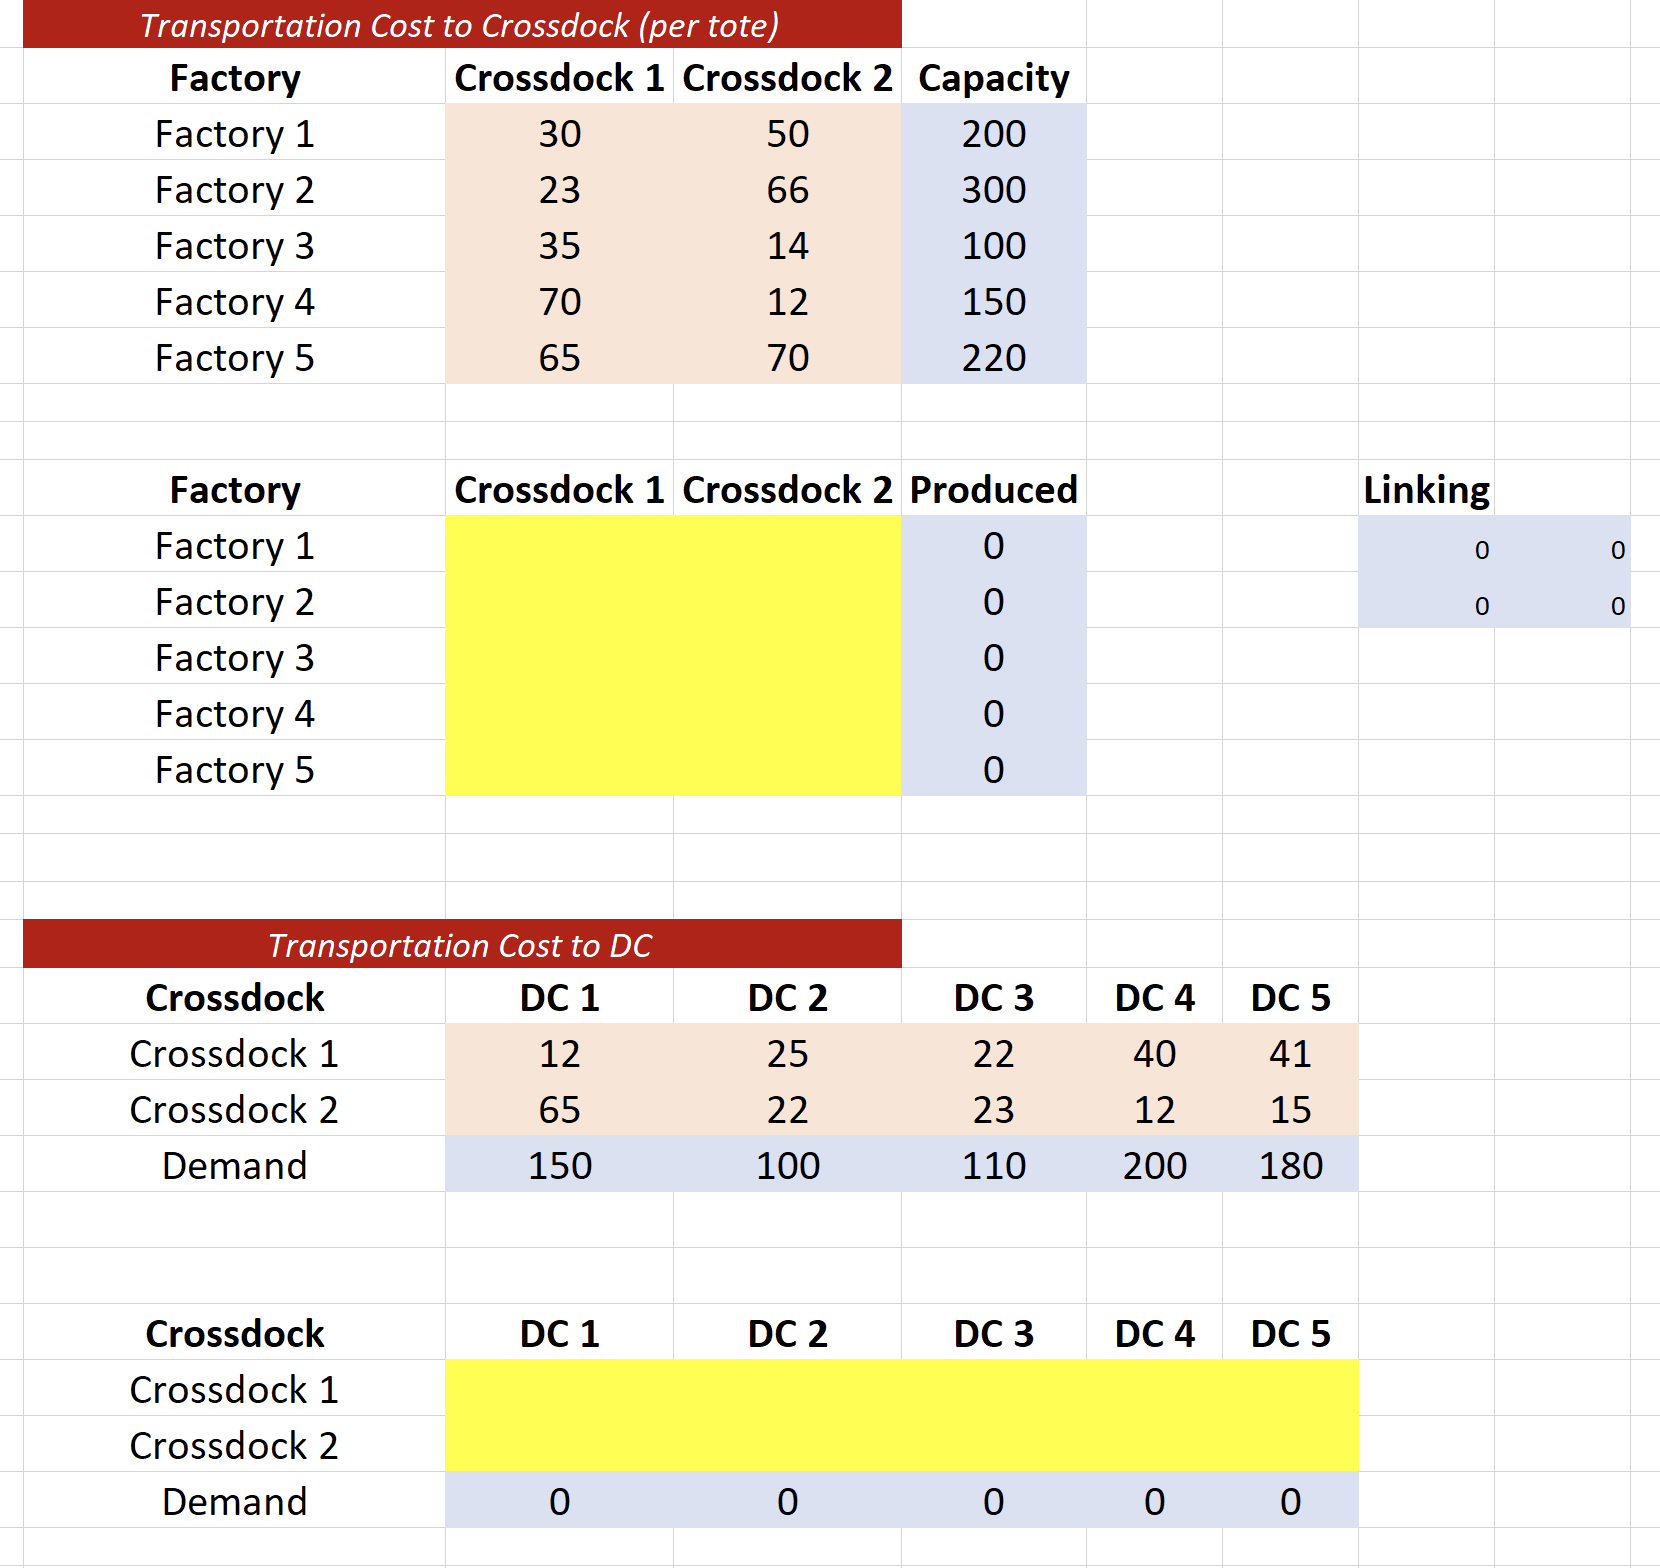

In [6]:
# Define the model
model = pyo.ConcreteModel()

# Define sets
model.i = pyo.RangeSet(1,5)
model.j = pyo.RangeSet(1,2)
model.p = pyo.RangeSet(1,5)

# Define parameters

model.InCost = pyo.Param(model.i,model.j, initialize={(1,1):30,(1,2):50,
                                                      (2,1):23,(2,2):66,
                                                      (3,1):35,(3,2):14,
                                                      (4,1):70,(4,2):12,
                                                      (5,1):65,(5,2):70})
InCost = model.InCost #Cost of transportation from plants to Cnetral Warehouse

model.Cap = pyo.Param(model.i, initialize={1:200,2:300,3:100,4:150,5:220})
Cap = model.Cap # Capacity of Factories


model.D = pyo.Param(model.p, initialize={1:150,2:100,3:110,4:200,5:180})
D = model.D # Demand of regional warehouse

model.Out_Cost = pyo.Param(model.j, model.p, initialize={(1,1):12,(1,2):25,(1,3):22,(1,4):40,(1,5):41,
                                                  (2,1):65,(2,2):22,(2,3):23,(2,4):12,(2,5):15})
Out_Cost = model.Out_Cost # Cost per distance from crossdocks to distribution centers

# Decision Variable
model.x = pyo.Var(model.i, model.j, within=pyo.NonNegativeReals)
x = model.x
model.z = pyo.Var(model.j, model.p, within=pyo.NonNegativeReals)
z = model.z


def objective_function(model):
  return sum(sum(x[i,j]*InCost[i,j] for i in model.i)for j in model.j)+sum(sum(z[j,p]*Out_Cost[j,p] for j in model.j) for p in model.p)
  

model.Obj = pyo.Objective(rule = objective_function, sense=pyo.minimize)


def cons1(model,i):
  return sum(x[i,j] for j in model.j)<=Cap[i] 
model.Cons1 = pyo.Constraint(model.i,rule=cons1)


def cons2(model,p):
  return sum(z[j,p] for j in model.j)>=D[p]
model.Cons2 = pyo.Constraint(model.i, rule=cons2)


def cons3(model,j):
  return sum(x[i,j] for i in model.i) -sum(z[j,p] for p in model.p)==0
model.Cons3 = pyo.Constraint(model.j, rule=cons3)

# Optimization
Solver = SolverFactory('glpk')
results = Solver.solve(model)

print("Objective funct: ",model.Obj())

for i in model.i:
  for j in model.j:
    print("From Factory ",i,x[i,j](),"amount of materials goes to Crossdock ",j)

for j in model.j:
  for p in model.p:
    print("from Crossdock ",j, z[j,p](),"amount goes to DC ",p)



Objective funct:  30220.0
From Factory  1 60.0 amount of materials goes to Crossdock  1
From Factory  1 130.0 amount of materials goes to Crossdock  2
From Factory  2 300.0 amount of materials goes to Crossdock  1
From Factory  2 0.0 amount of materials goes to Crossdock  2
From Factory  3 0.0 amount of materials goes to Crossdock  1
From Factory  3 100.0 amount of materials goes to Crossdock  2
From Factory  4 0.0 amount of materials goes to Crossdock  1
From Factory  4 150.0 amount of materials goes to Crossdock  2
From Factory  5 0.0 amount of materials goes to Crossdock  1
From Factory  5 0.0 amount of materials goes to Crossdock  2
from Crossdock  1 150.0 amount goes to DC  1
from Crossdock  1 100.0 amount goes to DC  2
from Crossdock  1 110.0 amount goes to DC  3
from Crossdock  1 0.0 amount goes to DC  4
from Crossdock  1 0.0 amount goes to DC  5
from Crossdock  2 0.0 amount goes to DC  1
from Crossdock  2 0.0 amount goes to DC  2
from Crossdock  2 0.0 amount goes to DC  3
from 